In [480]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import SimpleITK as sitk
import os

In [481]:
def registro_rigido(name, imagen_movil, imagen_referencia, imagen_seg, output_folder="../images/"):
    # Cargar las imágenes usando SimpleITK
    imagen_movil_sitk = sitk.ReadImage(imagen_movil)
    imagen_referencia_sitk = sitk.ReadImage(imagen_referencia)
    imagen_seg_sitk = sitk.ReadImage(imagen_seg)

    # Convertir la imagen móvil a tipo de datos float32
    imagen_movil_sitk = sitk.Cast(imagen_movil_sitk, sitk.sitkFloat32)
    imagen_seg_sitk = sitk.Cast(imagen_seg_sitk, sitk.sitkFloat32)
    imagen_referencia_sitk = sitk.ReadImage(imagen_referencia, sitk.sitkFloat32)

    # Crear el objeto de registro rígido
    registro_rigido = sitk.ImageRegistrationMethod()

    # Configurar los parámetros del registro rígido
    registro_rigido.SetMetricAsMeanSquares()
    registro_rigido.SetOptimizerAsRegularStepGradientDescent(learningRate=0.1, minStep=1e-4, numberOfIterations=100)
    registro_rigido.SetInitialTransform(sitk.TranslationTransform(imagen_movil_sitk.GetDimension()))

    # Realizar el registro rígido
    transformada_resultado = registro_rigido.Execute(imagen_referencia_sitk, imagen_movil_sitk)

    # Aplicar la transformación alineada a la imagen móvil completa
    imagen_movil_registrada = sitk.Resample(imagen_seg_sitk, imagen_referencia_sitk, transformada_resultado, sitk.sitkNearestNeighbor, 0.0, sitk.sitkFloat64)

    # Obtener la matriz tridimensional de la imagen móvil registrada y reordenar las dimensiones
    matriz_registrada = sitk.GetArrayFromImage(imagen_movil_registrada)
    matriz_registrada = np.transpose(matriz_registrada, (2, 1, 0))

    # Guardar la imagen registrada en formato NIfTI
    output_path = os.path.join(output_folder, name+".nii.gz")
    image_segmented = nib.Nifti1Image(matriz_registrada, affine=np.eye(4))
    nib.save(image_segmented, output_path)
    print(f"Imagen segmentada guardada en {output_path}")

    return matriz_registrada

In [482]:
def register_and_get_image_data_itk(name, routeM, moving, imagen_referencia):
    # Load fixed and moving images
    # route = filedialog.askopenfilename(filetypes=[("Image files", "FLAIR.nii.gz")])
    fixed_image = sitk.ReadImage(routeM)
    moving_image = sitk.ReadImage(moving)
    original_image = sitk.ReadImage(imagen_referencia)
    #moving_image_segmentation = sitk.ReadImage(moving_image_path)

    # Convert image types
    fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
    moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)
    original_image = sitk.Cast(original_image, sitk.sitkFloat32)
    #moving_image_segmentation = sitk.Cast(moving_image_segmentation, sitk.sitkFloat32)

    # Define the registration components
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric - Mutual Information
    registration_method.SetMetricAsMattesMutualInformation()

    # Interpolator
    registration_method.SetInterpolator(sitk.sitkNearestNeighbor)

    # Optimizer - Gradient Descent
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100,
                                                     estimateLearningRate=registration_method.EachIteration)

    # Initial transform - Identity
    initial_transform = sitk.Transform()
    registration_method.SetInitialTransform(initial_transform)

    # Setup for the registration process
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Perform registration
    final_transform = registration_method.Execute(fixed_image, original_image)

    # Resample the moving image to match the fixed image dimensions and orientation
    
    registered_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkNearestNeighbor, 0.0, fixed_image.GetPixelID())

    # Convert the resampled image to Numpy array
    #resampled_array = sitk.GetArrayFromImage(resampled_image)
    
    # Save the resampled image as NIfTI
    output_image_path = f'../images/{name}.nii.gz'
    sitk.WriteImage(registered_image, output_image_path)

In [483]:
def k_means(image, ks,iteracion=10):
        
    # Inicialización de valores k
    k_values = np.linspace(np.amin(image), np.amax(image), ks)
    # iteracion=10
    for i in range(iteracion):
        d_values = [np.abs(k - image) for k in k_values]
        segmentationr = np.argmin(d_values, axis=0)

        for k_idx in range(ks):
            k_values[k_idx] = np.mean(image[segmentationr == k_idx])

    return segmentationr

In [484]:
# prueba = nib.load('../images/FLAIR_IR.nii.gz').get_fdata()
# plt.imshow(prueba[:,:,25])

In [485]:
# register_and_get_image_data_itk("FLAIR_T1", routeM='../images/FLAIR.nii.gz', moving='../images/T1.nii.gz', imagen_referencia='../images/T1_seg.nii.gz')
# register_and_get_image_data_itk("FLAIR_IR", routeM='../images/FLAIR.nii.gz', moving='../images/IR.nii.gz', imagen_referencia='../images/IR_seg.nii.gz')

In [486]:
# T1 = nib.load('../images/FLAIR_T1.nii.gz').get_fdata()
# plt.imshow(T1[:,:,25])

In [487]:
# IR_image = nib.load('../images/FLAIR_IR.nii.gz').get_fdata()
# plt.imshow(IR_image[:,:,25])

In [488]:
image_registro_rigido = registro_rigido("T1_reg", imagen_movil='../images/T1.nii.gz', imagen_referencia='../images/FLAIR.nii.gz', imagen_seg='../images/seg_t1.nii.gz')
image_registro_rigido_IR = registro_rigido("IR_reg" , imagen_movil='../images/IR.nii.gz', imagen_referencia='../images/FLAIR.nii.gz', imagen_seg='../images/seg_ir.nii.gz')

Imagen segmentada guardada en ../images/T1_reg.nii.gz
Imagen segmentada guardada en ../images/IR_reg.nii.gz


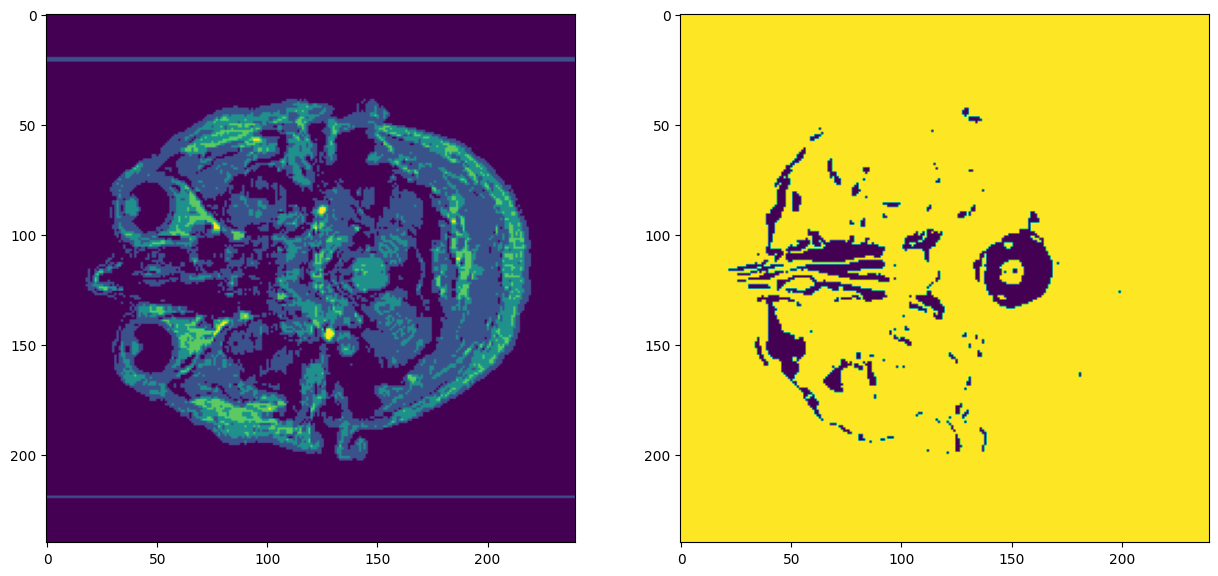

In [489]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(image_registro_rigido[:,:,5])
ax2.imshow(image_registro_rigido_IR[:,:,5])

In [490]:
# def remote():
#         # Cargar la imagen NIfTI
#     nifti_img = nib.load('../images/IR_reg.nii.gz')  # Asegúrate de ajustar la ruta y el nombre del archivo

#     # Obtener los datos de la imagen
#     data = nifti_img.get_fdata()

#     # Preprocesamiento opcional
#     # data = cv2.medianBlur(data, 5)  # Ejemplo de suavizado con filtro de mediana

#     # Definir escalas espaciales
#     scales = [7.5]  # Escalas para aplicar filtros gaussianos

#     # Aplicar filtros gaussianos en diferentes escalas
#     filtered_images = []
#     for scale in scales:
#         # Aplicar filtro gaussiano
#         filtered = ndimage.gaussian_filter(data, sigma=scale)
#         filtered = kMeans(filtered, 10, 2)
#         # Crear una nueva imagen nibabel con el cerebro extraído
#         brain_extracted_image = nib.Nifti1Image(filtered, affine=nifti_img.affine, dtype=np.int16)

        
#         # Guardar la imagen con el cerebro extraído en un nuevo archivo
#         nib.save(brain_extracted_image, '../images/IR_skull.nii.gz')
#         filtered_images.append(filtered)

#     # RESTAR UNA IMAGEN 

#     # Cargar las imágenes
#     imagen_original = sitk.ReadImage('../images/T1_reg.nii.gz')
#     imagen_referencia = sitk.ReadImage('../images/IR_skull.nii.gz')

#     # Realizar segmentación basada en umbral adaptativo
#     otsu_filter = sitk.OtsuThresholdImageFilter()
#     otsu_filter.SetInsideValue(1)
#     otsu_filter.SetOutsideValue(0)
#     mascara_referencia = otsu_filter.Execute(imagen_referencia)

#     # Aplicar la máscara a la imagen original
#     imagen_sin_craneo = sitk.Mask(imagen_original, mascara_referencia)

#     # Obtener los datos de la imagen sin el cráneo
#     # Obtener los datos de la imagen sin el cráneo
#     data_sin_craneo = sitk.GetArrayFromImage(imagen_sin_craneo)

#     # Obtener los datos de la máscara
#     data_mascara = sitk.GetArrayFromImage(mascara_referencia)

#     # Crear una máscara booleana para los valores cero dentro del cerebro
#     mascara_cero_cerebro = (data_sin_craneo == 0) & (data_mascara != 0)

#     # Asignar un valor distinto a los valores cero dentro del cerebro
#     valor_distinto = 6
#     data_sin_craneo[mascara_cero_cerebro] = valor_distinto

#     # Crear una nueva imagen SimpleITK con los datos modificados
#     imagen_sin_craneo_modificada = sitk.GetImageFromArray(data_sin_craneo)
#     imagen_sin_craneo_modificada.CopyInformation(imagen_sin_craneo)

#     # Guardar la imagen sin el cráneo
#     sitk.WriteImage(imagen_sin_craneo_modificada, '../images/FLAIR_skull.nii.gz')

    



In [491]:
# remote()

In [492]:
img = nib.load('../images/FLAIR_skull.nii.gz').get_fdata()

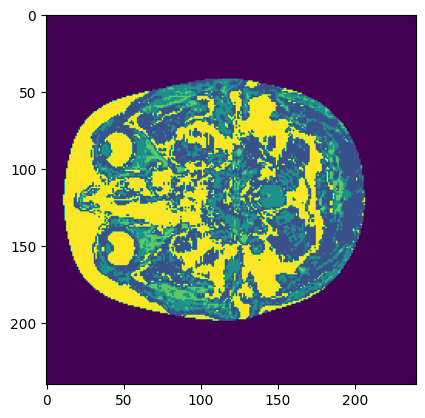

In [493]:
plt.imshow(img[:,:,5])

In [540]:
def remove_brain():
    # Cargar la imagen NIfTI

    nifti_img = nib.load(
        os.path.join("../images", "IR_reg.nii.gz")
    )  # Asegúrate de ajustar la ruta y el nombre del archivo

    # Obtener los datos de la imagen
    data = nifti_img.get_fdata()

    # Definir escalas espaciales
    scales = [10]  # Escalas para aplicar filtros gaussianos

    # Aplicar filtros gaussianos en diferentes escalas
    filtered_images = []
    for scale in scales:
        # Aplicar filtro gaussiano
        filtered = ndimage.gaussian_filter(data, sigma=scale)
        filtered = k_means(filtered, 6)
        # Crear una nueva imagen nibabel con el cerebro extraído
        brain_extracted_image = nib.Nifti1Image(
            filtered, affine=nifti_img.affine, dtype=np.int16
        )

        # Guardar la imagen con el cerebro extraído en un nuevo archivo
        nib.save(brain_extracted_image, os.path.join("../images", "IR_skull.nii.gz"))
        filtered_images.append(filtered)

    # RESTAR UNA IMAGEN

    # Cargar las imágenes
    imagen_original = sitk.ReadImage(
        os.path.join("../images", "T1_reg.nii.gz")
    )
    imagen_referencia = sitk.ReadImage(os.path.join("../images/", "IR_skull.nii.gz"))

    # Modify the metadata of image2 to match image1
    imagen_referencia.SetOrigin(imagen_original.GetOrigin())
    imagen_referencia.SetSpacing(imagen_original.GetSpacing())
    imagen_referencia.SetDirection(imagen_original.GetDirection())

    # Realizar segmentación basada en umbral adaptativo
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(1)
    otsu_filter.SetOutsideValue(0)
    mascara_referencia = otsu_filter.Execute(imagen_referencia)

    # Aplicar la máscara a la imagen original
    imagen_sin_craneo = sitk.Mask(imagen_original, mascara_referencia)

    # Obtener los datos de la imagen sin el cráneo
    # Obtener los datos de la imagen sin el cráneo
    data_sin_craneo = sitk.GetArrayFromImage(imagen_sin_craneo)

    # Obtener los datos de la máscara
    data_mascara = sitk.GetArrayFromImage(mascara_referencia)

    # Crear una máscara booleana para los valores cero dentro del cerebro
    mascara_cero_cerebro = (data_sin_craneo == 0) & (data_mascara != 0)

    # Asignar un valor distinto a los valores cero dentro del cerebro
    valor_distinto = 6
    data_sin_craneo[mascara_cero_cerebro] = valor_distinto

    # Crear una nueva imagen SimpleITK con los datos modificados
    imagen_sin_craneo_modificada = sitk.GetImageFromArray(data_sin_craneo)
    imagen_sin_craneo_modificada.CopyInformation(imagen_sin_craneo)

    # Guardar la imagen sin el cráneo

    sitk.WriteImage(
        imagen_sin_craneo_modificada, os.path.join("../images", "FLAIR_skull.nii.gz")
    )

    # ----------------------------------------------------------------------------------
    # Quitar cráneo a FLAIR Original
    # ----------------------------------------------------------------------------------
    # Cargar las imágenes

    imagen_original = sitk.ReadImage(os.path.join("../images", "FLAIR.nii.gz"))
    imagen_referencia = sitk.ReadImage(os.path.join("../images", "IR_skull.nii.gz"))

    imagen_referencia.SetOrigin(imagen_original.GetOrigin())
    imagen_referencia.SetSpacing(imagen_original.GetSpacing())
    imagen_referencia.SetDirection(imagen_original.GetDirection())


    # Realizar segmentación basada en umbral adaptativo
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(1)
    otsu_filter.SetOutsideValue(0)
    mascara_referencia = otsu_filter.Execute(imagen_referencia)

    # Aplicar la máscara a la imagen original
    imagen_sin_craneo = sitk.Mask(imagen_original, mascara_referencia)

    # Guardar la imagen sin el cráneo

    sitk.WriteImage(
        imagen_sin_craneo,
        os.path.join("../images", "FLAIR_original_sin_craneo.nii.gz"),
    )

    # ----------------------------------------------------------------------------------
    # Segmentar lesiones
    # ----------------------------------------------------------------------------------

    image = nib.load(os.path.join("../images", "FLAIR_skull.nii.gz"))
    image_data = image.get_fdata()
    image_data_flair_without_skull = nib.load(
        os.path.join("../images", "FLAIR_original_sin_craneo.nii.gz")
    ).get_fdata()

    image_data_flair_segmented = k_means(image_data_flair_without_skull, 20, 20)

    # Where the values are 3, replace them in the image_data with a value of 3
    image_data_flair_segmented[:,:,:13] = 0
    image_data = np.where(image_data_flair_segmented == 7, 3, image_data)

    affine = image.affine
    # Create a nibabel image object from the image data
    image = nib.Nifti1Image(image_data.astype(np.float32), affine=affine)
    # Save the image as a NIfTI file
    output_path = os.path.join("../images", "FLAIR_skull_lesion.nii.gz")
    nib.save(image, output_path)

    return image_data

In [542]:
remove_brain()

array([[[6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        ...,
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.]],

       [[6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        ...,
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.]],

       [[6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        ...,
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.]],

       ...,

       [[6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        ...,
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0., 0.],
        [6., 6., 6., ..., 0., 0.

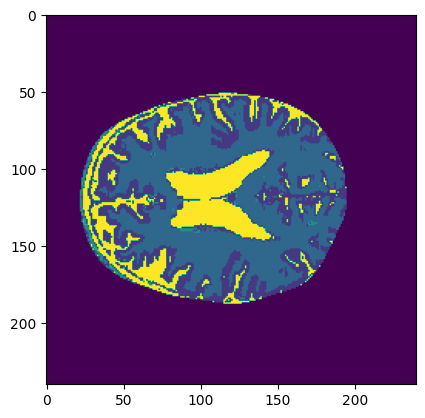

In [543]:
Removed_lessions = nib.load('../images/FLAIR_skull_lesion.nii.gz').get_fdata()
plt.imshow(Removed_lessions[:,:,25])


In [622]:
def volumes(file_path):

    image_data_FLAIR=nib.load(file_path).get_fdata()
    result= np.where(image_data_FLAIR == 4 , 1 , 0)
    unique,counts=np.unique(image_data_FLAIR, return_counts=True)
    print(counts)
    count= np.count_nonzero(image_data_FLAIR.astype(np.int32) == 2)
    print("Cantidad de elementos iguala a 1:", count)
    return counts

In [624]:
volumess = volumes(file_path="../images/FLAIR_skull_lesion.nii.gz")
print(volumess)

[1613490  353286  255153   29645     957  512269]
Cantidad de elementos iguala a 1: 255153
[1613490  353286  255153   29645     957  512269]
